In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.applications.mobilenet import MobileNet ,preprocess_input

(153, 329, 3)


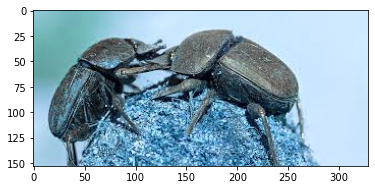

In [6]:
img=cv2.imread('jpg_0 - Copy (2).jpg')
print(img.shape)
plt.imshow(img)
plt.show()


In [7]:
img=np.array(img)
img.shape

(153, 329, 3)

In [8]:
train_dir='pest/train/'
test_dir='pest/test/'



training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=16,target_size=(224,224),shuffle=True)


Found 2565 images belonging to 9 classes.
Found 135 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


In [9]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17227776/17225924 [==============================] - 25s 1us/step


In [10]:
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.99)

/home/hp/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]
#model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
#callback=[EarlyStop , Reduce_LR,model_check]

In [12]:
mobilenet.trainable=False

In [13]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(9,activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [15]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [16]:
history=model.fit(training,validation_data=validing,epochs=20,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=2)

Epoch 1/20
10/10 - 15s - loss: 2.5647 - accuracy: 0.2750 - val_loss: 11.4545 - val_accuracy: 0.0625
Epoch 2/20
10/10 - 10s - loss: 2.0157 - accuracy: 0.5188 - val_loss: 7.2295 - val_accuracy: 0.2500
Epoch 3/20
10/10 - 10s - loss: 1.4905 - accuracy: 0.6000 - val_loss: 6.2507 - val_accuracy: 0.1875
Epoch 4/20
10/10 - 11s - loss: 1.3789 - accuracy: 0.6187 - val_loss: 6.2330 - val_accuracy: 0.2500
Epoch 5/20
10/10 - 10s - loss: 1.1440 - accuracy: 0.6938 - val_loss: 4.1105 - val_accuracy: 0.3125
Epoch 6/20
10/10 - 10s - loss: 0.7474 - accuracy: 0.7625 - val_loss: 2.8059 - val_accuracy: 0.5000
Epoch 7/20
10/10 - 10s - loss: 1.2272 - accuracy: 0.6625 - val_loss: 1.7713 - val_accuracy: 0.5000
Epoch 8/20
10/10 - 11s - loss: 1.0729 - accuracy: 0.7000 - val_loss: 2.3407 - val_accuracy: 0.5625
Epoch 9/20
10/10 - 11s - loss: 0.5339 - accuracy: 0.8062 - val_loss: 1.2798 - val_accuracy: 0.6250
Epoch 10/20
10/10 - 11s - loss: 0.7169 - accuracy: 0.7750 - val_loss: 0.7214 - val_accuracy: 0.8750
Epoch 11

In [17]:
loss , acc = model.evaluate(testing)

29/29 [==============================] - 23s 794ms/step - loss: 0.9984 - accuracy: 0.6644


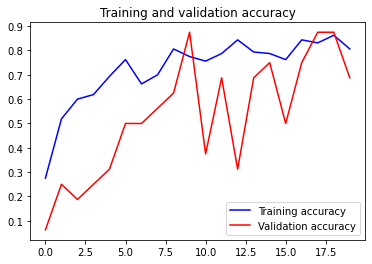

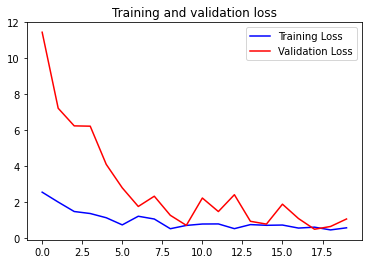

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()